# Assignment 1 for FIT5212, Semester 1

**Student Name:**  Tsz Yan CHUNG

**Student ID:**    32973381

In [ ]:
!pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip3 install torchtext==0.10.0

# Import Libraries


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 


In [ ]:
import copy
import random
import time
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy import data
from torchtext.legacy.data import Field, LabelField, TabularDataset, Dataset

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sunny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Sunny\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sunny\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sunny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%matplotlib inline
import nltk
import torch
import torchtext
from torchtext.legacy import data
from torchtext.legacy.data import Field, LabelField, TabularDataset, Dataset

import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve


from torchtext.legacy import data
from torchtext.legacy.data import Field, LabelField, TabularDataset, Dataset

import copy
import re
from nltk.stem import PorterStemmer

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
# Load spacy language model
spacy_en = spacy.load("en_core_web_sm")

# Load NLTK English stopwords
stop_words = set(stopwords.words('english'))

# Define NLTK WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Define Porter Stemmer
porter_stemmer = PorterStemmer()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sunny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Sunny\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sunny\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sunny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part 1:  Text Classification

In this task, we will first go  through the statisical method applied for this classification task, followed by the RNN algorithm.

Some parts of the code were assisted by ChatGPT, and those will be labelled for clarity


### Part 1A: Statistical Method

SVC algorithm was applied in this part of the task. 

Week 4 tutorial materials were referenced for this part of the code.

Code are put into functions for the sake of accessibility in further iterations.

In [ ]:
# Create empty df to store all evaluation values
metric_results_df = pd.DataFrame()

# Model training, building, and evaluating function

def evaluate_models(tokenizer, df_train, target_field, df_test, metric_results_df):
    
    # Preprocess and training data
    label_names = ["InformationTheory", "ComputationalLinguistics", "ComputerVision"]

    trainDocs = df_train[target_field].tolist()
    trainLabels = df_train[label_names].to_numpy()

    vectorizer = TfidfVectorizer(analyzer='word', input='content', lowercase=True, min_df=3, ngram_range=(1, 2), tokenizer=tokenizer)
    x_train = vectorizer.fit_transform(trainDocs)
    
    # Set up SVC model
    model = LinearSVC()
    CV = 5
    entries = []

    for idx, label_name in enumerate(label_names):
        accuracies = cross_val_score(model, x_train, trainLabels[:, idx], scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((label_name, model.__class__.__name__, fold_idx, accuracy))

    cv_df = pd.DataFrame(entries, columns=['label_name', 'model_name', 'fold_idx', 'accuracy'])
    sns.boxplot(x='label_name', y='accuracy', data=cv_df)
    sns.stripplot(x='label_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()

    testDocs = df_test[target_field].tolist()
    testLabels = df_test[label_names].to_numpy()
    x_test = vectorizer.transform(testDocs)

     # Create an empty list to store metric results
    metric_results = []

    for idx, label_name in enumerate(label_names):
        print(f"Evaluating for {label_name}")
        y_train, y_test = trainLabels[:, idx], testLabels[:, idx]
        model.fit(x_train, y_train)
        y_predict = model.predict(x_test)
        y_probs = model.decision_function(x_test)  # Get the decision function scores for precision-recall curve

        # Create a dictionary to store the evaluation metrics for the current label
        label_metric_results = {'label_name': label_name, 'model_name': model.__class__.__name__, "target_field": target_field, "train_size": len(trainDocs), "tokenizer": tokenizer.__name__}

        metrics = {
            'Accuracy': accuracy_score,
            'Macro Precision': precision_score,
            'Macro Recall': recall_score,
            'Macro F1 score': f1_score,
            'MCC': matthews_corrcoef
        }
        print(model.__class__.__name__)
        print(confusion_matrix(y_test, y_predict))
        for metric_name, metric_func in metrics.items():
            score = metric_func(y_test, y_predict, average='macro') if 'Macro' in metric_name else metric_func(y_test, y_predict)
            label_metric_results[metric_name] = score
            print(f'{metric_name}: {score}')


        # Get and store precision-recall curve values
        precision, recall, _ = precision_recall_curve(y_test, y_probs)
        label_metric_results['Recall'] = recall
        label_metric_results['Precision'] = precision
        
        # Append dictionary to list
        metric_results.append(label_metric_results)
        
        print('-------\n')
    return metric_results_df.append(metric_results, ignore_index = True)

In [ ]:
# Assited by ChatGPT to convert tokenization methods from the RNN application format to the SVC models

# Preprocessing method 1 (P1)
# Removing stopwords

def custom_tokenizer(text):
  
    return [tok.text for tok in spacy_en.tokenizer(text) if tok.text.lower() not in STOP_WORDS]

# Preprocessing method 2 (P2)
# Stemming tokens
def custom_tokenizer_P2(text):

    ps = PorterStemmer()

    return [ps.stem(tok.text) for tok in spacy_en.tokenizer(text)]

In [ ]:
# Splitting data

split_ratio = 0.9
SEED = 1
train_data = pd.read_csv('train.csv')
train_1000 = train_data.head(1000)
train_data, validation = train_test_split(train_data, test_size=1-split_ratio, random_state=SEED)
train_900, valid_100 = train_test_split(train_1000, test_size=1-split_ratio, random_state=SEED)
test_data = pd.read_csv("test.csv")

len(train_data), len(validation), len(train_900), len(valid_100)

(112500, 12500, 900, 100)

# P1 Title 1000

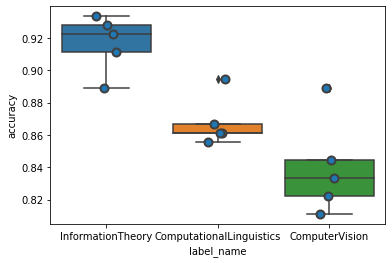

Evaluating for InformationTheory
LinearSVC
[[9249  338]
 [2616 5863]]
Accuracy: 0.8364884313074283
Macro Precision: 0.8625061289612967
Macro Recall: 0.8281084875655896
Macro F1 score: 0.8305355318330615
MCC: 0.6897574579712719
-------

Evaluating for ComputationalLinguistics
LinearSVC
[[13883   815]
 [ 1333  2035]]
Accuracy: 0.8811026237130521
Macro Precision: 0.8132149676241076
Macro Recall: 0.7743832154842596
Macro F1 score: 0.7913727296259354
MCC: 0.5863136701612914
-------

Evaluating for ComputerVision
LinearSVC
[[10027  1820]
 [ 1163  5056]]
Accuracy: 0.8348832060223624
Macro Precision: 0.8156895726207799
Macro Recall: 0.8296835260603406
Macro F1 score: 0.8213578922616693
MCC: 0.6452213618351478
-------



In [ ]:
# Defining parameters

tokenizer = custom_tokenizer
df_train = train_900
target_field = "title"
df_test = test_data
metric_results_df = evaluate_models(tokenizer, df_train, target_field, df_test, metric_results_df)

# P2 Title 1000

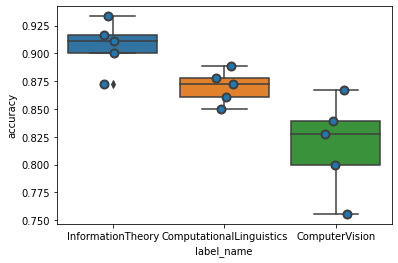

Evaluating for InformationTheory
LinearSVC
[[9245  342]
 [2424 6055]]
Accuracy: 0.8468947193623381
Macro Precision: 0.8694037784149105
Macro Recall: 0.8392219616007361
Macro F1 score: 0.8419674781353987
MCC: 0.707982695654716
-------

Evaluating for ComputationalLinguistics
LinearSVC
[[14082   616]
 [ 1310  2058]]
Accuracy: 0.8933909000332115
Macro Precision: 0.8422621801221277
Macro Recall: 0.7845673333163108
Macro F1 score: 0.808611702132926
MCC: 0.6241686819839032
-------

Evaluating for ComputerVision
LinearSVC
[[10159  1688]
 [ 1016  5203]]
Accuracy: 0.8503265803166169
Macro Precision: 0.8320627917554169
Macro Recall: 0.8470731770579797
Macro F1 score: 0.8381461807400622
MCC: 0.6789700674324157
-------



In [ ]:
# Defining parameters

tokenizer = custom_tokenizer_P2
df_train = train_900
target_field = "title"
df_test = test_data
metric_results_df = evaluate_models(tokenizer, df_train, target_field, df_test, metric_results_df)

# P1 Abstract 1000

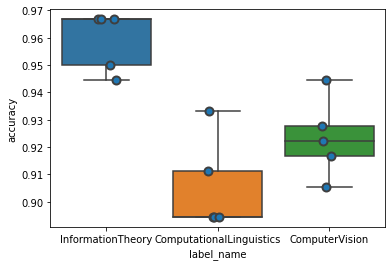

Evaluating for InformationTheory
LinearSVC
[[9524   63]
 [1297 7182]]
Accuracy: 0.9247204693900144
Macro Precision: 0.9357224077176827
Macro Recall: 0.9202312247810023
Macro F1 score: 0.9234337400519605
MCC: 0.8558134400901379
-------

Evaluating for ComputationalLinguistics
LinearSVC
[[14418   280]
 [  922  2446]]
Accuracy: 0.9334661795638215
Macro Precision: 0.9185905486880406
Macro Recall: 0.8535984099829053
Macro F1 score: 0.8813704151090274
MCC: 0.7694490300207364
-------

Evaluating for ComputerVision
LinearSVC
[[11088   759]
 [  523  5696]]
Accuracy: 0.9290379718808812
Macro Precision: 0.9186866189884708
Macro Recall: 0.925918012954281
Macro F1 score: 0.9220985849857695
MCC: 0.844573674252556
-------



In [ ]:
tokenizer = custom_tokenizer
df_train = train_900
target_field = "abstract"
df_test = test_data
metric_results_df = evaluate_models(tokenizer, df_train, target_field, df_test, metric_results_df)

# P2 Abstract 1000

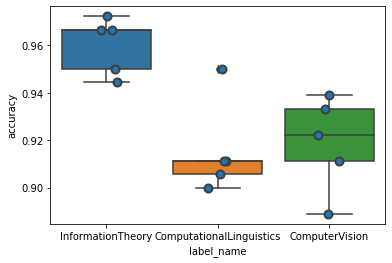

Evaluating for InformationTheory
LinearSVC
[[9513   74]
 [1287 7192]]
Accuracy: 0.9246651167939777
Macro Precision: 0.9353244563721442
Macro Recall: 0.920247223418344
Macro F1 score: 0.9234008159951866
MCC: 0.855438820901866
-------

Evaluating for ComputationalLinguistics
LinearSVC
[[14435   263]
 [  975  2393]]
Accuracy: 0.9314734861064984
Macro Precision: 0.9188541560792163
Macro Recall: 0.8463085489356736
Macro F1 score: 0.8766850361275769
MCC: 0.7617158919373275
-------

Evaluating for ComputerVision
LinearSVC
[[11104   743]
 [  517  5702]]
Accuracy: 0.9302557289936898
Macro Precision: 0.9201142043152531
Macro Recall: 0.9270756820632057
Macro F1 score: 0.9234076191544707
MCC: 0.8471612841776416
-------



In [ ]:
tokenizer = custom_tokenizer_P2
df_train = train_900
target_field = "abstract"
df_test = test_data
metric_results_df = evaluate_models(tokenizer, df_train, target_field, df_test, metric_results_df)

# P1 Title ALL

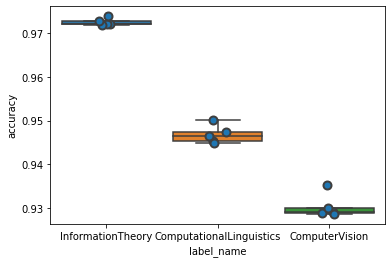

Evaluating for InformationTheory
LinearSVC
[[9407  180]
 [ 901 7578]]
Accuracy: 0.9401638436842688
Macro Precision: 0.9446951526397626
Macro Recall: 0.9374810219931994
Macro F1 score: 0.9395442009454607
MCC: 0.8821466768112096
-------

Evaluating for ComputationalLinguistics
LinearSVC
[[14318   380]
 [  514  2854]]
Accuracy: 0.9505147791431419
Macro Precision: 0.9239218267477629
Macro Recall: 0.9107666578644824
Macro F1 score: 0.917156095808995
MCC: 0.8345848116734086
-------

Evaluating for ComputerVision
LinearSVC
[[10957   890]
 [  406  5813]]
Accuracy: 0.9282630355363667
Macro Precision: 0.9157468151649284
Macro Recall: 0.9297958441100067
Macro F1 score: 0.9219339635066222
MCC: 0.8454259361052446
-------



In [ ]:
tokenizer = custom_tokenizer
df_train = train_data
target_field = "title"
df_test = test_data
metric_results_df = evaluate_models(tokenizer, df_train, target_field, df_test, metric_results_df)

# P2 Title ALL

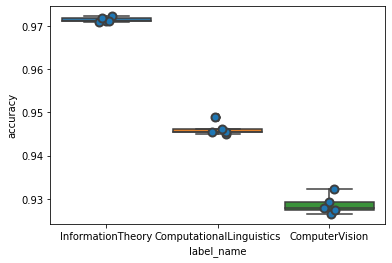

Evaluating for InformationTheory
LinearSVC
[[9408  179]
 [ 890 7589]]
Accuracy: 0.9408280748367098
Macro Precision: 0.9452660985835291
Macro Recall: 0.9381818373504347
Macro F1 score: 0.9402220613050182
MCC: 0.883419531564003
-------

Evaluating for ComputationalLinguistics
LinearSVC
[[14302   396]
 [  520  2848]]
Accuracy: 0.9492970220303332
Macro Precision: 0.9214227493007445
Macro Recall: 0.9093316297820668
Macro F1 score: 0.9152170972707914
MCC: 0.8306663850150988
-------

Evaluating for ComputerVision
LinearSVC
[[10981   866]
 [  431  5788]]
Accuracy: 0.9282076829403298
Macro Precision: 0.9160427288188252
Macro Recall: 0.928798789323482
Macro F1 score: 0.9217415622356171
MCC: 0.8447452122962283
-------



In [ ]:
tokenizer = custom_tokenizer_P2
df_train = train_data
target_field = "title"
df_test = test_data
metric_results_df = evaluate_models(tokenizer, df_train, target_field, df_test, metric_results_df)

# P1 Abstract ALL

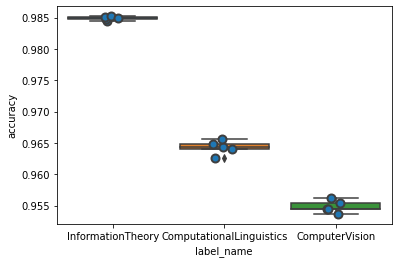

Evaluating for InformationTheory
LinearSVC
[[9491   96]
 [ 574 7905]]
Accuracy: 0.9629137606553747
Macro Precision: 0.9654860951620987
Macro Recall: 0.9611448888142682
Macro F1 score: 0.9626257190651313
MCC: 0.9266208147848048
-------

Evaluating for ComputationalLinguistics
LinearSVC
[[14468   230]
 [  314  3054]]
Accuracy: 0.9698881877560057
Macro Precision: 0.9543607040264099
Macro Recall: 0.9455606043319029
Macro F1 score: 0.9498834477913826
MCC: 0.8998782803705756
-------

Evaluating for ComputerVision
LinearSVC
[[11296   551]
 [  228  5991]]
Accuracy: 0.9568803276873685
Macro Precision: 0.9479950977057862
Macro Recall: 0.9584142461829718
Macro F1 score: 0.9528113601579944
MCC: 0.9063494580093591
-------



In [ ]:
tokenizer = custom_tokenizer
df_train = train_data
target_field = "abstract"
df_test = test_data
metric_results_df = evaluate_models(tokenizer, df_train, target_field, df_test, metric_results_df)

# P2 Abstract ALL

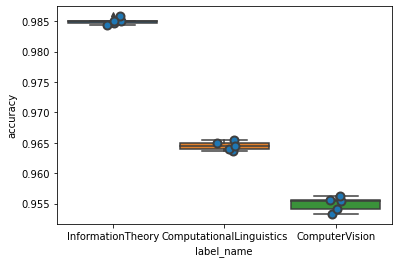

Evaluating for InformationTheory
LinearSVC
[[9488   99]
 [ 566 7913]]
Accuracy: 0.9631905236355585
Macro Precision: 0.9656737665532733
Macro Recall: 0.9614601806833571
Macro F1 score: 0.962908613838892
MCC: 0.9271243723539425
-------

Evaluating for ComputationalLinguistics
LinearSVC
[[14459   239]
 [  327  3041]]
Accuracy: 0.9686704306431971
Macro Precision: 0.9525093158327093
Macro Recall: 0.9433245114868505
Macro F1 score: 0.9478323799924282
MCC: 0.8957867411047895
-------

Evaluating for ComputerVision
LinearSVC
[[11290   557]
 [  249  5970]]
Accuracy: 0.9553858075943762
Macro Precision: 0.9465415897669222
Macro Recall: 0.9564726431807768
Macro F1 score: 0.9511497052804536
MCC: 0.9029596220674612
-------



In [ ]:
tokenizer = custom_tokenizer_P2
df_train = train_data
target_field = "abstract"
df_test = test_data
metric_results_df = evaluate_models(tokenizer, df_train, target_field, df_test, metric_results_df)

In [ ]:
# Saving all evaluation metrics into dataframe

metric_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   label_name       24 non-null     object 
 1   model_name       24 non-null     object 
 2   target_field     24 non-null     object 
 3   train_size       24 non-null     int64  
 4   tokenizer        24 non-null     object 
 5   Accuracy         24 non-null     float64
 6   Macro Precision  24 non-null     float64
 7   Macro Recall     24 non-null     float64
 8   Macro F1 score   24 non-null     float64
 9   MCC              24 non-null     float64
 10  Recall           24 non-null     object 
 11  Precision        24 non-null     object 
dtypes: float64(5), int64(1), object(6)
memory usage: 2.4+ KB


In [ ]:
metric_results_df

,label_name,model_name,target_field,train_size,tokenizer,Accuracy,Macro Precision,Macro Recall,Macro F1 score,MCC,Recall,Precision
0,InformationTheory,LinearSVC,title,900,custom_tokenizer,0.836488,0.862506,0.828108,0.830536,0.689757,"[1.0, 0.9998820615638636, 0.9998820615638636, ...","[0.4696986483492134, 0.4696692704005318, 0.469..."
1,ComputationalLinguistics,LinearSVC,title,900,custom_tokenizer,0.881103,0.813215,0.774383,0.791373,0.586314,"[1.0, 0.9997030878859857, 0.9997030878859857, ...","[0.1894050163086267, 0.1893594286035656, 0.189..."
2,ComputerVision,LinearSVC,title,900,custom_tokenizer,0.834883,0.815690,0.829684,0.821358,0.645221,"[1.0, 0.9998392024441228, 0.9998392024441228, ...","[0.3449633902817839, 0.3450418955662838, 0.345..."
3,InformationTheory,LinearSVC,title,900,custom_tokenizer_P2,0.846895,0.869404,0.839222,0.841967,0.707983,"[1.0, 0.9998820615638636, 0.9998820615638636, ...","[0.47076786408306037, 0.47073847862298723, 0.4..."
4,ComputationalLinguistics,LinearSVC,title,900,custom_tokenizer_P2,0.893391,0.842262,0.784567,0.808612,0.624169,"[1.0, 0.9997030878859857, 0.9997030878859857, ...","[0.1878835211424746, 0.18784869448783753, 0.18..."
5,ComputerVision,LinearSVC,title,900,custom_tokenizer_P2,0.850327,0.832063,0.847073,0.838146,0.678970,"[1.0, 0.9998392024441228, 0.9998392024441228, ...","[0.34650100289725877, 0.34646459018220316, 0.3..."
6,InformationTheory,LinearSVC,abstract,900,custom_tokenizer,0.924720,0.935722,0.920231,0.923434,0.855813,"[1.0, 0.9998820615638636, 0.9998820615638636, ...","[0.5016862907520265, 0.5016568047337278, 0.501..."
7,ComputationalLinguistics,LinearSVC,abstract,900,custom_tokenizer,0.933466,0.918591,0.853598,0.881370,0.769449,"[1.0, 0.9997030878859857, 0.9997030878859857, ...","[0.19767578354266932, 0.19764029114815684, 0.1..."
8,ComputerVision,LinearSVC,abstract,900,custom_tokenizer,0.929038,0.918687,0.925918,0.922099,0.844574,"[1.0, 0.9998392024441228, 0.9998392024441228, ...","[0.3492446790587971, 0.34920813209030666, 0.34..."
9,InformationTheory,LinearSVC,abstract,900,custom_tokenizer_P2,0.924665,0.935324,0.920247,0.923401,0.855439,"[1.0, 0.9998820615638636, 0.9998820615638636, ...","[0.48741089905725454, 0.48738143144581775, 0.4..."


# Libraries imports should have been integrated to the first part of the code.

This part is left here for error handling purpose.

In [ ]:
# # Import Libraries
# import torch
# import torchtext

# from torchtext.legacy import data
# import torch.nn as nn
# from torchtext.legacy.data import Field, LabelField, TabularDataset, Dataset
# import copy

# import torch.optim as optim
# import collections
# import random
# import time
# import pandas as pd
# import re
# import spacy
# from nltk.stem import PorterStemmer

# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
# import numpy as np
# spacy_en = spacy.load("en_core_web_sm")
# from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
# import torch
# import torchtext
# import torch.nn as nn
# import torch.optim as optim

# from torchtext.legacy import data
# from torchtext.legacy.data import Field, LabelField, TabularDataset
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
# from sklearn.metrics import precision_recall_curve

# import spacy
# from spacy.lang.en.stop_words import STOP_WORDS
# import numpy as np
# import random
# import time
# import copy
# import collections

# from nltk.stem import PorterStemmer


### Part 1B: RNN Method

Code was referenced to Week 4 tutorial material on Building RNN models, and converted into functions for the sake of accessibility.

Summarising codes into functions were assisted by ChatGPT.

In [1]:
# I accidentally re-run this cell. Hopefully it will not affect the output of the later part in this notebook.

spacy_en = spacy.load("en_core_web_sm")
SEED = 1
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

NameError: ignored

In [ ]:
def load_data(path, train_file, test_file, target_field, tokenizer, MAX_VOCAB_SIZE):
    TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True)
    LABEL = data.LabelField(dtype=torch.float, use_vocab=False, preprocessing=int)
    if target_field == "title":
        train_datafield = [
            (target_field, TEXT),
            ("abstract", None), 
            ("InformationTheory", LABEL),
            ("ComputationalLinguistics", LABEL),
            ("ComputerVision", LABEL)
        ]
    else:
        train_datafield = [
            ("title", None),
            (target_field, TEXT), 
            ("InformationTheory", LABEL),
            ("ComputationalLinguistics", LABEL),
            ("ComputerVision", LABEL)
        ]
        
    train_data, test_data = TabularDataset.splits(
        path=path,
        train=train_file, test=test_file, format="csv",
        skip_header=True, fields=train_datafield
    )
    train_data, valid_data = train_data.split(split_ratio=0.9, random_state=random.getstate())

    MAX_VOCAB_SIZE = MAX_VOCAB_SIZE

    TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
    
    return TEXT, LABEL, train_data, valid_data, test_data


In [ ]:
def generate_label_iterator(train_data, valid_data, test_data, label, target_field):
    
    label_attr = f"label_{label}"
    BATCH_SIZE = 64
    iterators = data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size = BATCH_SIZE,
        device = device,
        sort_key = lambda x: len(getattr(x, target_field)),
        sort_within_batch = False)
    return iterators[0], iterators[1], iterators[2]

In [ ]:

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pos_weight = None):
        
        super(RNN, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.pos_weight = pos_weight

        if self.pos_weight is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        else:
            self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, text):

        embedded = self.embedding(text)
        
        output, hidden = self.rnn(embedded)

        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [ ]:
# Assisted by ChatGPT

def get_pos_weight(train_data):
    pos_weights = []
    for field in ["InformationTheory", "ComputationalLinguistics", "ComputerVision"]:
        negative_count, positive_count = 0, 0
        for example in train_data.examples:
            if getattr(example, field) == 0:
                negative_count += 1
            else:
                positive_count += 1
        
        pos_weights.append(torch.tensor([negative_count / positive_count]).to(device))
    return pos_weights


In [ ]:
def generate_model_and_optimizer(pos_weight, embedding_dim=100, hidden_dim=256, output_dim=1, lr=1e-2):
    INPUT_DIM = len(TEXT.vocab)

    model = RNN(INPUT_DIM, embedding_dim, hidden_dim, output_dim, pos_weight)

    optimizer = optim.SGD(model.parameters(), lr=lr)

    model = model.to(device)
    
    return model, optimizer

In [ ]:
# Evaluation functions

def binary_accuracy(preds, y):

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion, label_field, target_field):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:

        optimizer.zero_grad()
                
        predictions = model(getattr(batch, target_field)).squeeze(1)
        
        # Use the specific label field
        loss = criterion(predictions, getattr(batch, label_field))
        
        acc = binary_accuracy(predictions, getattr(batch, label_field))
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, label_field, target_field):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(getattr(batch, target_field)).squeeze(1)
            
            # Use the specific label field
            loss = criterion(predictions, getattr(batch, label_field))
            
            acc = binary_accuracy(predictions, getattr(batch, label_field))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
    
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Assisted by ChatGPT to build up the train_loop, creating early stopping and error handling

rnn_results_df = pd.DataFrame()

def train_loop(ModelsList, OptimizersList, IteratorsList, N_EPOCHS, label_names, target_field, modelFileNames, bestLossesList, preprocess, train_size, patience=5, rnn_metric_results=[]):
    result = []
    best_model_states = []
    best_epochs = [0, 0, 0]
    for idx, (label_name, model, optimizer, iterators_) in enumerate(zip(label_names, ModelsList, OptimizersList, IteratorsList)):
        print(f"Training model for {preprocess}_{label_name}, using {train_size} data of {target_field}...")

        bad_epochs = 0
        best_model_state = None
        best_epoch = 0

        for epoch in range(N_EPOCHS):
            start_time = time.time()

            train_iterator = iterators_[0]
            test_iterator = iterators_[2] if len(iterators_) > 2 else iterators_[1]
            valid_iterator = iterators_[1] if len(iterators_) > 2 else None

            train_loss, train_acc = train(model, train_iterator, optimizer, model.criterion, label_name, target_field)

            if valid_iterator:
                valid_loss, valid_acc = evaluate(model, valid_iterator, model.criterion, label_name, target_field)

            test_loss, test_acc = evaluate(model, test_iterator, model.criterion, label_name, target_field)

            end_time = time.time()
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            if test_loss < bestLossesList[idx]:
                bestLossesList[idx] = test_loss
                best_model_state = copy.deepcopy(model.state_dict())
#                 best_model_state = model.state_dict()
                bad_epochs = 0
                best_epochs[idx] = epoch + 1
        
                print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
                print(f'{label_name} Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                print(f'{label_name} Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')
                print(f'{label_name} Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
            else:
                bad_epochs += 1
        
            if bad_epochs > patience:
                print(f"Early stopping at epoch {epoch+1} for {label_name} model.")
#                 model.load_state_dict(best_model_state)
                break

            # For predictions and ground truth collection
            model.eval()
            y_predict, y_test = [], []
            with torch.no_grad():
                for batch in test_iterator:
                    predictions = model(getattr(batch, target_field)).squeeze(1)
                    rounded_preds = torch.round(torch.sigmoid(predictions))
                    y_predict += rounded_preds.tolist()
                    y_test += getattr(batch, label_name).tolist()
        print(f"Best performing epoch for {label_name} model: {best_epochs[idx]}")
        best_model_states.append(best_model_state)
        
        model.load_state_dict(best_model_state)
        # Call 'evaluate_model' and store its return value
        rnn_eval_metrics = evaluate_model(model, test_iterator, label_name, target_field)
#         print(rnn_eval_metrics)
        # Append the evaluation metrics to the 'rnn_metric_results' list
        rnn_metric_results.append({
            "accuracy": rnn_eval_metrics["accuracy"],
            'label_name': label_name,
            'model_name': model.__class__.__name__,
            'target_field': target_field,
            'train_size': train_size,
            'tokenizer': preprocess,
            **rnn_eval_metrics
        })
#         result.append((y_predict, y_test))
        
    return rnn_metric_results, best_model_states



In [ ]:
# Assisted by ChatGPT to return evaluatiton matrics to df


def evaluate_model(model, iterator, label_field, target_field):
    

    y_probs = []
    y_predict = []
    y_test = []
    
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(getattr(batch, target_field)).squeeze(1)
            probs = torch.sigmoid(predictions)
            rounded_preds = torch.round(torch.sigmoid(predictions))
            
            y_predict += rounded_preds.tolist()
            y_test += getattr(batch, label_field).tolist()
            y_probs += probs.tolist()
    
    y_predict = np.asarray(y_predict)
    y_test = np.asarray(y_test)
    y_probs = np.asarray(y_probs)
    # Compute metrics
    recall_macro = recall_score(y_test, y_predict, average='macro')
    precision_macro = precision_score(y_test, y_predict, average='macro')
#     recall = recall_score(y_test, y_predict, average=None)
#     precision = precision_score(y_test, y_predict, average=None)
    f1score = f1_score(y_test, y_predict, average='macro')
    accuracy = accuracy_score(y_test, y_predict)
    matthews = matthews_corrcoef(y_test, y_predict)
#     precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_probs)
    precision, recall, _ = precision_recall_curve(y_test, y_probs)

    # Print metrics
    
    print(f"{label_field}:")
    print(confusion_matrix(y_test, y_predict))
    print('Accuracy:', accuracy)
    print('Macro Precision:', precision_macro)
    print('Macro Recall:', recall_macro)
    print('Macro F1 score:', f1score)
    print('MCC:', matthews)
    print("\n")
    return {
        "accuracy": accuracy,
        'Macro Recall': recall_macro,
        'Macro Precision': precision_macro,
        'Macro F1 score': f1score,
        'MCC': matthews,
        'Recall': recall,
        'Precision': precision  
    }


<h2>P1 Title 1000</h2>

In [ ]:
def custom_tokenizer(text):   
    return [tok.text for tok in spacy_en.tokenizer(text) if tok.text.lower() not in STOP_WORDS]

path = './'
train_file = "train_1000.csv"
test_file = "test.csv"
target_field = "title"
tokenizer = custom_tokenizer
MAX_VOCAB_SIZE = 5000

TEXT, LABEL, train_data, valid_data, test_data = load_data(path, train_file, test_file, target_field, custom_tokenizer, MAX_VOCAB_SIZE)


train_iterator_IT, validation_IT, test_iterator_IT = generate_label_iterator(train_data, valid_data, test_data, "InformationTheory", target_field)
train_iterator_CL, validation_CL, test_iterator_CL = generate_label_iterator(train_data, valid_data, test_data, "ComputationalLinguistics", target_field)
train_iterator_CV, validation_CV, test_iterator_CV = generate_label_iterator(train_data, valid_data, test_data, "ComputerVision", target_field)

pos_weights = get_pos_weight(train_data)

model_IT, optimizer_IT = generate_model_and_optimizer(pos_weight=pos_weights[0])
model_CL, optimizer_CL = generate_model_and_optimizer(pos_weight=pos_weights[1])
model_CV, optimizer_CV = generate_model_and_optimizer(pos_weight=pos_weights[2])

N_EPOCHS = 2
label_names = ["InformationTheory", "ComputationalLinguistics", "ComputerVision"]
models = [model_IT, model_CL, model_CV]
optimizers = [optimizer_IT, optimizer_CL, optimizer_CV]
iterators = [(train_iterator_IT, validation_IT, test_iterator_IT), (train_iterator_CL, validation_CL, test_iterator_CL), (train_iterator_CV, validation_CV, test_iterator_CV)]
model_file_names = ["RNN_model_IT_T_P1_1000", "RNN_model_CL_T_P1_1000.pt", "RNN_model_CV_T_P1_1000.pt"]
best_valid_losses = [float("inf"), float("inf"), float("inf")]

In [ ]:
# Making sure data are loaded correctly

# print(TEXT.vocab.freqs.most_common(200))
len(train_data), len(valid_data), len(test_data), len(TEXT.vocab)



(900, 100, 18066, 2497)

In [ ]:
# Run model and store output

rnn_results, best_model_states = train_loop(models, optimizers, iterators, N_EPOCHS, label_names, target_field, model_file_names, best_valid_losses, "P1", len(train_data), 10, rnn_metric_results=[])
rnn_results_df = rnn_results_df.append(pd.DataFrame(rnn_results), ignore_index = True)


Training model for P1_InformationTheory, using 900 data of title...
Epoch: 01 | Epoch Time: 0m 2s
InformationTheory Train Loss: 1.057 | Train Acc: 40.73%
InformationTheory Valid Loss: 0.978 | Valid Acc: 22.05%
InformationTheory Test Loss: 1.323 | Test Acc: 51.96%
Best performing epoch for InformationTheory model: 1
InformationTheory:
[[6510 3077]
 [5607 2872]]
Accuracy: 0.5193180560168272
Macro Precision: 0.5100159559607327
Macro Recall: 0.5088818640320529
Macro F1 score: 0.4990020990638365
MCC: 0.01886375985791359


Training model for P1_ComputationalLinguistics, using 900 data of title...
Epoch: 01 | Epoch Time: 0m 0s
ComputationalLinguistics Train Loss: 1.085 | Train Acc: 49.38%
ComputationalLinguistics Valid Loss: 1.272 | Valid Acc: 67.36%
ComputationalLinguistics Test Loss: 1.002 | Test Acc: 54.41%
Best performing epoch for ComputationalLinguistics model: 1
ComputationalLinguistics:
[[8274 6424]
 [1828 1540]]
Accuracy: 0.5432303775047049
Macro Precision: 0.5062079496319858
Macro R

In [ ]:
rnn_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   accuracy         3 non-null      float64
 1   label_name       3 non-null      object 
 2   model_name       3 non-null      object 
 3   target_field     3 non-null      object 
 4   train_size       3 non-null      int64  
 5   tokenizer        3 non-null      object 
 6   Macro Recall     3 non-null      float64
 7   Macro Precision  3 non-null      float64
 8   Macro F1 score   3 non-null      float64
 9   MCC              3 non-null      float64
 10  Recall           3 non-null      object 
 11  Precision        3 non-null      object 
dtypes: float64(5), int64(1), object(6)
memory usage: 416.0+ bytes


<h2>P2 Title 1000</h2>

In [ ]:
def custom_tokenizer_P2(text):
    ps = PorterStemmer()
    return [ps.stem(tok.text) for tok in spacy_en.tokenizer(text)]

path = './'
train_file = "train_1000.csv"
test_file = "test.csv"
target_field = "title"
tokenizer = custom_tokenizer_P2
MAX_VOCAB_SIZE = 5000

TEXT, LABEL, train_data, valid_data, test_data = load_data(path, train_file, test_file, target_field, tokenizer, MAX_VOCAB_SIZE)


train_iterator_IT, validation_IT, test_iterator_IT = generate_label_iterator(train_data, valid_data, test_data, "InformationTheory", target_field)
train_iterator_CL, validation_CL, test_iterator_CL = generate_label_iterator(train_data, valid_data, test_data, "ComputationalLinguistics", target_field)
train_iterator_CV, validation_CV, test_iterator_CV = generate_label_iterator(train_data, valid_data, test_data, "ComputerVision", target_field)

pos_weights = get_pos_weight(train_data)

model_IT, optimizer_IT = generate_model_and_optimizer(pos_weight=pos_weights[0])
model_CL, optimizer_CL = generate_model_and_optimizer(pos_weight=pos_weights[1])
model_CV, optimizer_CV = generate_model_and_optimizer(pos_weight=pos_weights[2])

N_EPOCHS = 30
label_names = ["InformationTheory", "ComputationalLinguistics", "ComputerVision"]
models = [model_IT, model_CL, model_CV]
optimizers = [optimizer_IT, optimizer_CL, optimizer_CV]
iterators = [(train_iterator_IT, validation_IT, test_iterator_IT), (train_iterator_CL, validation_CL, test_iterator_CL), (train_iterator_CV, validation_CV, test_iterator_CV)]
model_file_names = ["RNN_model_IT_T_P2_1000", "RNN_model_CL_T_P2_1000.pt", "RNN_model_CV_T_P2_1000.pt"]
best_valid_losses = [float("inf"), float("inf"), float("inf")]

In [ ]:
print(TEXT.vocab.freqs.most_common(200))
len(train_data), len(valid_data), len(test_data), len(TEXT.vocab)



[('-', 602), ('\n  ', 444), ('for', 353), ('of', 247), (':', 221), ('and', 202), ('a', 157), ('in', 153), ('learn', 143), ('with', 130), ('the', 128), ('network', 122), ('imag', 99), ('on', 91), ('model', 82), ('base', 79), ('use', 75), ('code', 70), ('neural', 68), ('to', 68), ('deep', 66), ('detect', 61), ('system', 46), ('segment', 46), ('channel', 44), ('gener', 44), ('multi', 43), ('video', 38), ('from', 38), ('convolut', 37), ('data', 36), ('via', 36), ('recognit', 35), ('estim', 34), ('object', 33), ('classif', 33), ('analysi', 32), ('by', 31), ('supervis', 29), ('languag', 29), ('train', 28), ('graph', 27), ('distribut', 26), ('robust', 26), ('featur', 26), ('improv', 26), ('optim', 26), ('inform', 25), ('time', 25), ('face', 25), ('commun', 24), ('semant', 24), ('an', 24), ('effici', 24), ('text', 23), ('attent', 23), ('predict', 23), ('adversari', 23), ('shot', 22), ('local', 22), ('adapt', 21), ('joint', 21), ('visual', 21), ('end', 21), ('non', 21), ('comput', 21), ('repres

(900, 100, 18066, 2072)

In [ ]:
rnn_results, best_model_states = train_loop(models, optimizers, iterators, N_EPOCHS, label_names, target_field, model_file_names, best_valid_losses, "P2", len(train_data), 10, rnn_metric_results=[])
rnn_results_df = rnn_results_df.append(pd.DataFrame(rnn_results), ignore_index = True)


Training model for P2_InformationTheory, using 900 data of title...
Epoch: 01 | Epoch Time: 0m 0s
InformationTheory Train Loss: 1.043 | Train Acc: 42.08%
InformationTheory Valid Loss: 0.979 | Valid Acc: 21.88%
InformationTheory Test Loss: 1.278 | Test Acc: 49.41%
Epoch: 06 | Epoch Time: 0m 0s
InformationTheory Train Loss: 1.076 | Train Acc: 38.12%
InformationTheory Valid Loss: 0.976 | Valid Acc: 21.09%
InformationTheory Test Loss: 1.274 | Test Acc: 49.83%
Epoch: 07 | Epoch Time: 0m 0s
InformationTheory Train Loss: 1.051 | Train Acc: 32.71%
InformationTheory Valid Loss: 0.977 | Valid Acc: 21.09%
InformationTheory Test Loss: 1.273 | Test Acc: 49.94%
Epoch: 16 | Epoch Time: 0m 0s
InformationTheory Train Loss: 1.063 | Train Acc: 44.90%
InformationTheory Valid Loss: 0.981 | Valid Acc: 21.09%
InformationTheory Test Loss: 1.271 | Test Acc: 50.46%
Epoch: 17 | Epoch Time: 0m 0s
InformationTheory Train Loss: 1.056 | Train Acc: 42.29%
InformationTheory Valid Loss: 0.987 | Valid Acc: 21.09%
Inform

<h2> P1 Title ALL</h2>

In [ ]:
path = './'
train_file = "train.csv"
test_file = "test.csv"
target_field = "title"
tokenizer = custom_tokenizer
MAX_VOCAB_SIZE = 5000

TEXT, LABEL, train_data, valid_data, test_data = load_data(path, train_file, test_file, target_field, tokenizer, MAX_VOCAB_SIZE)


train_iterator_IT, validation_IT, test_iterator_IT = generate_label_iterator(train_data, valid_data, test_data, "InformationTheory", target_field)
train_iterator_CL, validation_CL, test_iterator_CL = generate_label_iterator(train_data, valid_data, test_data, "ComputationalLinguistics", target_field)
train_iterator_CV, validation_CV, test_iterator_CV = generate_label_iterator(train_data, valid_data, test_data, "ComputerVision", target_field)

pos_weights = get_pos_weight(train_data)

model_IT, optimizer_IT = generate_model_and_optimizer(pos_weight=pos_weights[0])
model_CL, optimizer_CL = generate_model_and_optimizer(pos_weight=pos_weights[1])
model_CV, optimizer_CV = generate_model_and_optimizer(pos_weight=pos_weights[2])

N_EPOCHS = 30
label_names = ["InformationTheory", "ComputationalLinguistics", "ComputerVision"]
models = [model_IT, model_CL, model_CV]
optimizers = [optimizer_IT, optimizer_CL, optimizer_CV]
iterators = [(train_iterator_IT, validation_IT, test_iterator_IT), (train_iterator_CL, validation_CL, test_iterator_CL), (train_iterator_CV, validation_CV, test_iterator_CV)]
model_file_names = ["RNN_model_IT_T_P1_ALL", "RNN_model_CL_T_P1_ALL.pt", "RNN_model_CV_T_P1_ALL.pt"]
best_valid_losses = [float("inf"), float("inf"), float("inf")]

In [ ]:
print(TEXT.vocab.freqs.most_common(50))
len(train_data), len(valid_data), len(test_data), len(TEXT.vocab)

[('-', 75468), ('\n  ', 55134), (':', 27878), ('learning', 15463), ('based', 10302), ('networks', 9578), ('deep', 8907), ('image', 8776), ('neural', 8550), ('detection', 7319), ('network', 6780), ('multi', 6580), ('segmentation', 5257), ('recognition', 5182), ('data', 4233), ('language', 4157), ('analysis', 4128), ('classification', 4113), ('object', 3735), ('codes', 3656), ('convolutional', 3652), ('images', 3621), ('estimation', 3490), ('models', 3472), ('model', 3468), ('visual', 3402), ('3d', 3395), ('information', 3203), ('text', 3135), ('semantic', 3121), ('video', 3039), ('adversarial', 2935), ('supervised', 2892), ('systems', 2797), ('domain', 2761), ('approach', 2723), ('channel', 2708), ('attention', 2620), ('generation', 2529), ('end', 2471), ('efficient', 2470), ('machine', 2328), ('unsupervised', 2275), ('time', 2242), ('self', 2229), ('graph', 2201), ('training', 2199), ('mimo', 2190), ('translation', 2137), ('robust', 2044)]


(112500, 12500, 18066, 5002)

In [ ]:
rnn_results, best_model_states = train_loop(models, optimizers, iterators, N_EPOCHS, label_names, target_field, model_file_names, best_valid_losses, "P1", len(train_data), 10, rnn_metric_results=[])
rnn_results_df = rnn_results_df.append(pd.DataFrame(rnn_results), ignore_index = True)


Training model for P1_InformationTheory, using 112500 data of title...
Epoch: 01 | Epoch Time: 0m 7s
InformationTheory Train Loss: 1.055 | Train Acc: 49.65%
InformationTheory Valid Loss: 1.047 | Valid Acc: 62.46%
InformationTheory Test Loss: 1.403 | Test Acc: 56.39%
Epoch: 02 | Epoch Time: 0m 7s
InformationTheory Train Loss: 1.023 | Train Acc: 53.57%
InformationTheory Valid Loss: 0.835 | Valid Acc: 79.02%
InformationTheory Test Loss: 1.219 | Test Acc: 72.96%
Epoch: 03 | Epoch Time: 0m 7s
InformationTheory Train Loss: 0.726 | Train Acc: 78.34%
InformationTheory Valid Loss: 0.693 | Valid Acc: 82.35%
InformationTheory Test Loss: 1.116 | Test Acc: 76.28%
Epoch: 04 | Epoch Time: 0m 7s
InformationTheory Train Loss: 0.606 | Train Acc: 82.28%
InformationTheory Valid Loss: 0.578 | Valid Acc: 84.75%
InformationTheory Test Loss: 0.921 | Test Acc: 80.68%
Epoch: 05 | Epoch Time: 0m 7s
InformationTheory Train Loss: 0.450 | Train Acc: 87.37%
InformationTheory Valid Loss: 0.448 | Valid Acc: 87.98%
Inf

<h2> P2 Title ALL</h2>

In [ ]:
path = './'
train_file = "train.csv"
test_file = "test.csv"
target_field = "title"
tokenizer = custom_tokenizer_P2
MAX_VOCAB_SIZE = 5000

TEXT, LABEL, train_data, valid_data, test_data = load_data(path, train_file, test_file, target_field, tokenizer, MAX_VOCAB_SIZE)


train_iterator_IT, validation_IT, test_iterator_IT = generate_label_iterator(train_data, valid_data, test_data, "InformationTheory", target_field)
train_iterator_CL, validation_CL, test_iterator_CL = generate_label_iterator(train_data, valid_data, test_data, "ComputationalLinguistics", target_field)
train_iterator_CV, validation_CV, test_iterator_CV = generate_label_iterator(train_data, valid_data, test_data, "ComputerVision", target_field)

pos_weights = get_pos_weight(train_data)

model_IT, optimizer_IT = generate_model_and_optimizer(pos_weight=pos_weights[0])
model_CL, optimizer_CL = generate_model_and_optimizer(pos_weight=pos_weights[1])
model_CV, optimizer_CV = generate_model_and_optimizer(pos_weight=pos_weights[2])

N_EPOCHS = 30
label_names = ["InformationTheory", "ComputationalLinguistics", "ComputerVision"]
models = [model_IT, model_CL, model_CV]
optimizers = [optimizer_IT, optimizer_CL, optimizer_CV]
iterators = [(train_iterator_IT, validation_IT, test_iterator_IT), (train_iterator_CL, validation_CL, test_iterator_CL), (train_iterator_CV, validation_CV, test_iterator_CV)]
model_file_names = ["RNN_model_IT_T_P2_ALL", "RNN_model_CL_T_P2_ALL.pt", "RNN_model_CV_T_P2_ALL.pt"]
best_valid_losses = [float("inf"), float("inf"), float("inf")]

In [ ]:
print(TEXT.vocab.freqs.most_common(50))
len(train_data), len(valid_data), len(test_data), len(TEXT.vocab)

[('-', 75468), ('\n  ', 55134), ('for', 44553), ('of', 28257), (':', 27878), ('and', 27386), ('a', 19077), ('in', 18409), ('with', 17399), ('network', 16408), ('learn', 16123), ('the', 14608), ('imag', 13192), ('base', 10667), ('on', 10513), ('use', 10390), ('to', 10239), ('deep', 8910), ('model', 8615), ('neural', 8556), ('detect', 8103), ('gener', 7305), ('code', 6700), ('multi', 6580), ('from', 6341), ('segment', 5600), ('recognit', 5183), ('channel', 4631), ('languag', 4611), ('object', 4469), ('via', 4420), ('system', 4397), ('convolut', 4273), ('data', 4234), ('classif', 4133), ('analysi', 4128), ('an', 4081), ('estim', 3941), ('video', 3937), ('visual', 3792), ('semant', 3540), ('by', 3458), ('supervis', 3446), ('inform', 3430), ('text', 3425), ('3d', 3395), ('represent', 3362), ('featur', 3317), ('optim', 3223), ('adapt', 3160)]


(112500, 12500, 18066, 5002)

In [ ]:
rnn_results, best_model_states = train_loop(models, optimizers, iterators, N_EPOCHS, label_names, target_field, model_file_names, best_valid_losses, "P2", len(train_data), 10, rnn_metric_results=[])
rnn_results_df = rnn_results_df.append(pd.DataFrame(rnn_results), ignore_index = True)


Training model for P2_InformationTheory, using 112500 data of title...
Epoch: 01 | Epoch Time: 0m 8s
InformationTheory Train Loss: 1.056 | Train Acc: 49.97%
InformationTheory Valid Loss: 1.030 | Valid Acc: 69.32%
InformationTheory Test Loss: 1.400 | Test Acc: 60.53%
Epoch: 02 | Epoch Time: 0m 8s
InformationTheory Train Loss: 1.054 | Train Acc: 49.77%
InformationTheory Valid Loss: 1.009 | Valid Acc: 74.31%
InformationTheory Test Loss: 1.397 | Test Acc: 62.80%
Epoch: 03 | Epoch Time: 0m 8s
InformationTheory Train Loss: 1.037 | Train Acc: 54.01%
InformationTheory Valid Loss: 1.026 | Valid Acc: 63.11%
InformationTheory Test Loss: 1.360 | Test Acc: 60.11%
Epoch: 04 | Epoch Time: 0m 8s
InformationTheory Train Loss: 1.057 | Train Acc: 49.82%
InformationTheory Valid Loss: 1.002 | Valid Acc: 62.06%
InformationTheory Test Loss: 1.321 | Test Acc: 60.98%
Epoch: 05 | Epoch Time: 0m 8s
InformationTheory Train Loss: 1.054 | Train Acc: 50.56%
InformationTheory Valid Loss: 0.975 | Valid Acc: 55.68%
Inf

<h2> P1 Abstract 1000</h2>

In [ ]:
path = './'
train_file = "train_1000.csv"
test_file = "test.csv"
target_field = "abstract"
tokenizer = custom_tokenizer
MAX_VOCAB_SIZE = 10000

TEXT, LABEL, train_data, valid_data, test_data = load_data(path, train_file, test_file, target_field, tokenizer, MAX_VOCAB_SIZE)


train_iterator_IT, validation_IT, test_iterator_IT = generate_label_iterator(train_data, valid_data, test_data, "InformationTheory", target_field)
train_iterator_CL, validation_CL, test_iterator_CL = generate_label_iterator(train_data, valid_data, test_data, "ComputationalLinguistics", target_field)
train_iterator_CV, validation_CV, test_iterator_CV = generate_label_iterator(train_data, valid_data, test_data, "ComputerVision", target_field)

pos_weights = get_pos_weight(train_data)

model_IT, optimizer_IT = generate_model_and_optimizer(pos_weight=pos_weights[0])
model_CL, optimizer_CL = generate_model_and_optimizer(pos_weight=pos_weights[1])
model_CV, optimizer_CV = generate_model_and_optimizer(pos_weight=pos_weights[2])

N_EPOCHS = 30
label_names = ["InformationTheory", "ComputationalLinguistics", "ComputerVision"]
models = [model_IT, model_CL, model_CV]
optimizers = [optimizer_IT, optimizer_CL, optimizer_CV]
iterators = [(train_iterator_IT, validation_IT, test_iterator_IT), (train_iterator_CL, validation_CL, test_iterator_CL), (train_iterator_CV, validation_CV, test_iterator_CV)]
model_file_names = ["RNN_model_IT_A_P1_1000", "RNN_model_CL_A_P1_1000.pt", "RNN_model_CV_A_P1_1000.pt"]
best_valid_losses = [float("inf"), float("inf"), float("inf")]

In [ ]:
print(TEXT.vocab.freqs.most_common(50))
len(train_data), len(valid_data), len(test_data), len(TEXT.vocab)

[('\n', 12514), ('.', 6196), ('-', 4941), (')', 1610), ('(', 1537), ('  ', 900), ('model', 622), ('based', 602), ('data', 560), ('$', 549), ('image', 547), ('learning', 503), ('proposed', 490), ('models', 450), ('network', 444), ('paper', 429), ('performance', 425), ('results', 418), ('method', 412), ('methods', 390), ('propose', 383), ('images', 380), ('information', 348), ('training', 346), ('state', 337), ('approach', 317), ('new', 315), ('problem', 313), ('neural', 294), ('deep', 289), ('networks', 281), ('art', 273), ('different', 262), ('dataset', 260), ('time', 250), ('%', 244), ('datasets', 231), ('high', 228), ('algorithm', 228), ('large', 227), ('work', 225), ('novel', 222), ('system', 219), ('task', 217), ('number', 211), ('classification', 209), ('codes', 206), ('features', 205), ('detection', 205), ('channel', 204)]


(900, 100, 18066, 10002)

In [ ]:
rnn_results, best_model_states = train_loop(models, optimizers, iterators, N_EPOCHS, label_names, target_field, model_file_names, best_valid_losses, "P1", len(train_data), 10, rnn_metric_results=[])
rnn_results_df = rnn_results_df.append(pd.DataFrame(rnn_results), ignore_index = True)


Training model for P1_InformationTheory, using 900 data of abstract...
Epoch: 01 | Epoch Time: 0m 2s
InformationTheory Train Loss: 1.044 | Train Acc: 66.67%
InformationTheory Valid Loss: 0.937 | Valid Acc: 19.62%
InformationTheory Test Loss: 1.205 | Test Acc: 47.76%
Epoch: 06 | Epoch Time: 0m 2s
InformationTheory Train Loss: 1.053 | Train Acc: 40.10%
InformationTheory Valid Loss: 0.917 | Valid Acc: 19.62%
InformationTheory Test Loss: 1.192 | Test Acc: 47.85%
Epoch: 11 | Epoch Time: 0m 2s
InformationTheory Train Loss: 1.026 | Train Acc: 66.98%
InformationTheory Valid Loss: 0.936 | Valid Acc: 19.62%
InformationTheory Test Loss: 1.183 | Test Acc: 47.78%
Epoch: 17 | Epoch Time: 0m 2s
InformationTheory Train Loss: 1.093 | Train Acc: 42.40%
InformationTheory Valid Loss: 0.933 | Valid Acc: 18.84%
InformationTheory Test Loss: 1.181 | Test Acc: 47.85%
Epoch: 25 | Epoch Time: 0m 2s
InformationTheory Train Loss: 1.057 | Train Acc: 50.21%
InformationTheory Valid Loss: 0.992 | Valid Acc: 18.06%
Inf

<h2> P2 Abstract 1000</h2>

In [ ]:
path = './'
train_file = "train_1000.csv"
test_file = "test.csv"
target_field = "abstract"
tokenizer = custom_tokenizer_P2
MAX_VOCAB_SIZE = 10000

TEXT, LABEL, train_data, valid_data, test_data = load_data(path, train_file, test_file, target_field, tokenizer, MAX_VOCAB_SIZE)


train_iterator_IT, validation_IT, test_iterator_IT = generate_label_iterator(train_data, valid_data, test_data, "InformationTheory", target_field)
train_iterator_CL, validation_CL, test_iterator_CL = generate_label_iterator(train_data, valid_data, test_data, "ComputationalLinguistics", target_field)
train_iterator_CV, validation_CV, test_iterator_CV = generate_label_iterator(train_data, valid_data, test_data, "ComputerVision", target_field)

pos_weights = get_pos_weight(train_data)

model_IT, optimizer_IT = generate_model_and_optimizer(pos_weight=pos_weights[0])
model_CL, optimizer_CL = generate_model_and_optimizer(pos_weight=pos_weights[1])
model_CV, optimizer_CV = generate_model_and_optimizer(pos_weight=pos_weights[2])

N_EPOCHS = 30
label_names = ["InformationTheory", "ComputationalLinguistics", "ComputerVision"]
models = [model_IT, model_CL, model_CV]
optimizers = [optimizer_IT, optimizer_CL, optimizer_CV]
iterators = [(train_iterator_IT, validation_IT, test_iterator_IT), (train_iterator_CL, validation_CL, test_iterator_CL), (train_iterator_CV, validation_CV, test_iterator_CV)]
model_file_names = ["RNN_model_IT_A_P2_1000", "RNN_model_CL_A_P2_1000.pt", "RNN_model_CV_A_P2_1000.pt"]
best_valid_losses = [float("inf"), float("inf"), float("inf")]

In [ ]:
print(TEXT.vocab.freqs.most_common(50))
len(train_data), len(valid_data), len(test_data), len(TEXT.vocab)

[('\n', 12514), ('the', 8593), ('.', 6196), ('of', 4993), ('-', 4941), ('and', 4018), ('to', 3641), ('a', 3591), ('in', 2890), ('we', 2209), ('is', 1893), ('for', 1865), (')', 1610), ('(', 1537), ('that', 1502), ('on', 1431), ('thi', 1285), ('with', 1186), ('model', 1146), ('imag', 961), ('by', 933), ('as', 916), ('propos', 916), ('are', 906), ('  ', 900), ('use', 899), ('method', 802), ('our', 802), ('an', 735), ('network', 727), ('learn', 703), ('from', 662), ('base', 643), ('can', 641), ('which', 628), ('it', 606), ('train', 590), ('perform', 570), ('be', 563), ('data', 560), ('$', 549), ('gener', 538), ('result', 513), ('dataset', 491), ('approach', 466), ('show', 461), ('code', 436), ('paper', 429), ('problem', 409), ('task', 392)]


(900, 100, 18066, 7054)

In [ ]:
rnn_results, best_model_states = train_loop(models, optimizers, iterators, N_EPOCHS, label_names, target_field, model_file_names, best_valid_losses, "P2", len(train_data), 10, rnn_metric_results=[])
rnn_results_df = rnn_results_df.append(pd.DataFrame(rnn_results), ignore_index = True)


Training model for P2_InformationTheory, using 900 data of abstract...
Epoch: 01 | Epoch Time: 0m 3s
InformationTheory Train Loss: 1.046 | Train Acc: 42.92%
InformationTheory Valid Loss: 0.949 | Valid Acc: 18.66%
InformationTheory Test Loss: 1.237 | Test Acc: 48.40%
Epoch: 06 | Epoch Time: 0m 3s
InformationTheory Train Loss: 1.044 | Train Acc: 41.46%
InformationTheory Valid Loss: 0.941 | Valid Acc: 18.66%
InformationTheory Test Loss: 1.220 | Test Acc: 49.67%
Epoch: 07 | Epoch Time: 0m 3s
InformationTheory Train Loss: 1.056 | Train Acc: 37.50%
InformationTheory Valid Loss: 0.948 | Valid Acc: 19.44%
InformationTheory Test Loss: 1.214 | Test Acc: 49.52%
Epoch: 11 | Epoch Time: 0m 3s
InformationTheory Train Loss: 1.029 | Train Acc: 64.69%
InformationTheory Valid Loss: 0.960 | Valid Acc: 19.44%
InformationTheory Test Loss: 1.205 | Test Acc: 48.69%
Epoch: 17 | Epoch Time: 0m 3s
InformationTheory Train Loss: 1.090 | Train Acc: 42.29%
InformationTheory Valid Loss: 0.970 | Valid Acc: 19.44%
Inf

<h2> P1 Abstract ALL</h2>

In [ ]:
path = './'
train_file = "train.csv"
test_file = "test.csv"
target_field = "abstract"
tokenizer = custom_tokenizer
MAX_VOCAB_SIZE = 10000

TEXT, LABEL, train_data, valid_data, test_data = load_data(path, train_file, test_file, target_field, tokenizer, MAX_VOCAB_SIZE)


train_iterator_IT, validation_IT, test_iterator_IT = generate_label_iterator(train_data, valid_data, test_data, "InformationTheory", target_field)
train_iterator_CL, validation_CL, test_iterator_CL = generate_label_iterator(train_data, valid_data, test_data, "ComputationalLinguistics", target_field)
train_iterator_CV, validation_CV, test_iterator_CV = generate_label_iterator(train_data, valid_data, test_data, "ComputerVision", target_field)

pos_weights = get_pos_weight(train_data)

model_IT, optimizer_IT = generate_model_and_optimizer(pos_weight=pos_weights[0])
model_CL, optimizer_CL = generate_model_and_optimizer(pos_weight=pos_weights[1])
model_CV, optimizer_CV = generate_model_and_optimizer(pos_weight=pos_weights[2])

N_EPOCHS = 30
label_names = ["InformationTheory", "ComputationalLinguistics", "ComputerVision"]
models = [model_IT, model_CL, model_CV]
optimizers = [optimizer_IT, optimizer_CL, optimizer_CV]
iterators = [(train_iterator_IT, validation_IT, test_iterator_IT), (train_iterator_CL, validation_CL, test_iterator_CL), (train_iterator_CV, validation_CV, test_iterator_CV)]
model_file_names = ["RNN_model_IT_A_P2_1000", "RNN_model_CL_A_P2_1000.pt", "RNN_model_CV_A_P2_1000.pt"]
best_valid_losses = [float("inf"), float("inf"), float("inf")]

In [ ]:
# print(TEXT.vocab.freqs.most_common(50))
len(train_data), len(valid_data), len(test_data), len(TEXT.vocab)

(112500, 12500, 18066, 10002)

In [ ]:
rnn_results, best_model_states = train_loop(models, optimizers, iterators, N_EPOCHS, label_names, target_field, model_file_names, best_valid_losses, "P1", len(train_data), 10, rnn_metric_results=[])
rnn_results_df = rnn_results_df.append(pd.DataFrame(rnn_results), ignore_index = True)


Training model for P1_InformationTheory, using 112500 data of abstract...
Epoch: 01 | Epoch Time: 0m 41s
InformationTheory Train Loss: 1.056 | Train Acc: 50.58%
InformationTheory Valid Loss: 1.066 | Valid Acc: 50.25%
InformationTheory Test Loss: 1.404 | Test Acc: 50.53%
Epoch: 02 | Epoch Time: 0m 42s
InformationTheory Train Loss: 1.055 | Train Acc: 50.38%
InformationTheory Valid Loss: 1.070 | Valid Acc: 49.32%
InformationTheory Test Loss: 1.393 | Test Acc: 51.08%
Epoch: 03 | Epoch Time: 0m 42s
InformationTheory Train Loss: 1.055 | Train Acc: 50.67%
InformationTheory Valid Loss: 1.063 | Valid Acc: 51.26%
InformationTheory Test Loss: 1.373 | Test Acc: 52.37%
Epoch: 04 | Epoch Time: 0m 42s
InformationTheory Train Loss: 1.054 | Train Acc: 51.37%
InformationTheory Valid Loss: 1.056 | Valid Acc: 52.25%
InformationTheory Test Loss: 1.371 | Test Acc: 53.45%
Epoch: 05 | Epoch Time: 0m 42s
InformationTheory Train Loss: 1.054 | Train Acc: 51.23%
InformationTheory Valid Loss: 1.057 | Valid Acc: 50

<h2> P2 Abstract ALL</h2>

In [ ]:
path = './'
train_file = "train.csv"
test_file = "test.csv"
target_field = "abstract"
tokenizer = custom_tokenizer_P2
MAX_VOCAB_SIZE = 10000

TEXT, LABEL, train_data, valid_data, test_data = load_data(path, train_file, test_file, target_field, tokenizer, MAX_VOCAB_SIZE)

train_iterator_IT, validation_IT, test_iterator_IT = generate_label_iterator(train_data, valid_data, test_data, "InformationTheory", target_field)
train_iterator_CL, validation_CL, test_iterator_CL = generate_label_iterator(train_data, valid_data, test_data, "ComputationalLinguistics", target_field)
train_iterator_CV, validation_CV, test_iterator_CV = generate_label_iterator(train_data, valid_data, test_data, "ComputerVision", target_field)

pos_weights = get_pos_weight(train_data)

model_IT, optimizer_IT = generate_model_and_optimizer(pos_weight=pos_weights[0])
model_CL, optimizer_CL = generate_model_and_optimizer(pos_weight=pos_weights[1])
model_CV, optimizer_CV = generate_model_and_optimizer(pos_weight=pos_weights[2])

N_EPOCHS = 30
label_names = ["InformationTheory", "ComputationalLinguistics", "ComputerVision"]
models = [model_IT, model_CL, model_CV]
optimizers = [optimizer_IT, optimizer_CL, optimizer_CV]
iterators = [(train_iterator_IT, validation_IT, test_iterator_IT), (train_iterator_CL, validation_CL, test_iterator_CL), (train_iterator_CV, validation_CV, test_iterator_CV)]
model_file_names = ["RNN_model_IT_A_P2_ALL", "RNN_model_CL_A_P2_ALL.pt", "RNN_model_CV_A_P2_ALL.pt"]
best_valid_losses = [float("inf"), float("inf"), float("inf")]

In [ ]:
# print(TEXT.vocab.freqs.most_common(50))
len(train_data), len(valid_data), len(test_data), len(TEXT.vocab)

(112500, 12500, 18066, 10002)

In [ ]:
rnn_results, best_model_states = train_loop(models, optimizers, iterators, N_EPOCHS, label_names, target_field, model_file_names, best_valid_losses, "P2", len(train_data), 5, rnn_metric_results=[])
rnn_results_df = rnn_results_df.append(pd.DataFrame(rnn_results), ignore_index = True)

Training model for P2_InformationTheory, using 112500 data of abstract...
Epoch: 01 | Epoch Time: 0m 55s
InformationTheory Train Loss: 1.055 | Train Acc: 52.35%
InformationTheory Valid Loss: 1.098 | Valid Acc: 28.84%
InformationTheory Test Loss: 1.278 | Test Acc: 46.84%
Epoch: 04 | Epoch Time: 0m 55s
InformationTheory Train Loss: 1.053 | Train Acc: 53.38%
InformationTheory Valid Loss: 1.103 | Valid Acc: 28.24%
InformationTheory Test Loss: 1.264 | Test Acc: 47.33%
Epoch: 05 | Epoch Time: 0m 55s
InformationTheory Train Loss: 1.053 | Train Acc: 54.15%
InformationTheory Valid Loss: 1.102 | Valid Acc: 28.20%
InformationTheory Test Loss: 1.259 | Test Acc: 46.79%
Epoch: 10 | Epoch Time: 0m 55s
InformationTheory Train Loss: 1.053 | Train Acc: 54.33%
InformationTheory Valid Loss: 1.096 | Valid Acc: 28.48%
InformationTheory Test Loss: 1.257 | Test Acc: 46.83%
Epoch: 12 | Epoch Time: 0m 56s
InformationTheory Train Loss: 1.053 | Train Acc: 54.59%
InformationTheory Valid Loss: 1.094 | Valid Acc: 28

In [ ]:
rnn_results_df.columns

Index(['accuracy', 'label_name', 'model_name', 'target_field', 'train_size',
       'tokenizer', 'Macro Recall', 'Macro Precision', 'Macro F1 score', 'MCC',
       'Recall', 'Precision'],
      dtype='object')

# Storing output

In [ ]:
metric_results_df.to_csv("svc_results.csv", index = False)

In [ ]:
rnn_results_df.to_csv("rnn_results.csv", index = False)

### Part 1C:  Results for Methods

F1, precision, etc.

In [2]:
from google.colab import drive
drive.mount('/content/drive') 


Mounted at /content/drive


In [5]:
import pandas as pd
import os

os.chdir("/content/drive/MyDrive/")

rnn_results = pd.read_csv("rnn_results.csv")
svc_results = pd.read_csv("svc_results.csv")


In [6]:
combined_df = pd.concat([rnn_results, svc_results], ignore_index = True)

In [7]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   accuracy         24 non-null     float64
 1   label_name       48 non-null     object 
 2   model_name       48 non-null     object 
 3   target_field     48 non-null     object 
 4   train_size       48 non-null     int64  
 5   tokenizer        48 non-null     object 
 6   Macro Recall     48 non-null     float64
 7   Macro Precision  48 non-null     float64
 8   Macro F1 score   48 non-null     float64
 9   MCC              48 non-null     float64
 10  Recall           48 non-null     object 
 11  Precision        48 non-null     object 
 12  Accuracy         24 non-null     float64
dtypes: float64(6), int64(1), object(6)
memory usage: 5.0+ KB


# RNN models result

In [11]:
rnn_results = rnn_results[['label_name', 'model_name', 'target_field', 'train_size',
                               'tokenizer', 'accuracy','Macro Recall', 'Macro Precision', 'Macro F1 score', 'MCC',
                               'Recall', 'Precision']]
rnn_results = rnn_results.rename(columns = {"accuracy": "Accuracy"})
rnn_results

,label_name,model_name,target_field,train_size,tokenizer,Accuracy,Macro Recall,Macro Precision,Macro F1 score,MCC,Recall,Precision
0,InformationTheory,RNN,title,900,P1,0.519318,0.508882,0.510016,0.499002,0.018864,[1.00000000e+00 9.99882062e-01 9.99882062e-01 ...,[0.46933466 0.46930529 0.46935725 ... 1. ...
1,ComputationalLinguistics,RNN,title,900,P1,0.543230,0.510089,0.506208,0.469527,0.015828,[1. 0.99970309 0.99970309 ... 0. ...,[0.18644818 0.18641346 0.18642379 ... 0. ...
2,ComputerVision,RNN,title,900,P1,0.507307,0.517316,0.515680,0.498965,0.032955,[1.00000000e+00 9.99839202e-01 9.99678405e-01 ...,[0.34423779 0.34420149 0.34416519 ... 0.5 ...
3,InformationTheory,RNN,title,900,P2,0.504318,0.509258,0.509465,0.503109,0.018722,[1.00000000e+00 9.99882062e-01 9.99882062e-01 ...,[0.46936064 0.46933127 0.46935725 ... 1. ...
4,ComputationalLinguistics,RNN,title,900,P2,0.445201,0.514157,0.508955,0.418964,0.022519,[1.00000000e+00 9.99703088e-01 9.99703088e-01 ...,[0.18642754 0.18638251 0.18639283 ... 1. ...
5,ComputerVision,RNN,title,900,P2,0.533654,0.502878,0.502706,0.501098,0.005581,[1.00000000e+00 9.99839202e-01 9.99839202e-01 ...,[0.34423779 0.34420149 0.34422055 ... 0.5 ...
6,InformationTheory,RNN,title,112500,P1,0.902358,0.902221,0.901871,0.902033,0.804092,[1.00000000e+00 9.99882062e-01 9.99882062e-01 ...,[0.4760274 0.47599798 0.47602471 ... 1. ...
7,ComputationalLinguistics,RNN,title,112500,P1,0.888022,0.870071,0.808354,0.832918,0.675612,[1.00000000e+00 9.99703088e-01 9.99703088e-01 ...,[0.18698645 0.18695169 0.18696207 ... 1. ...
8,ComputerVision,RNN,title,112500,P1,0.867431,0.868899,0.850107,0.857339,0.718761,[1.00000000e+00 9.99839202e-01 9.99839202e-01 ...,[0.38757323 0.38753506 0.38755921 ... 1. ...
9,InformationTheory,RNN,title,112500,P2,0.724289,0.726427,0.725973,0.724263,0.452400,[1.00000000e+00 9.99882062e-01 9.99882062e-01 ...,[0.4694386 0.46940922 0.46943522 ... 1. ...


# SVC models result

In [10]:
svc_results

,label_name,model_name,target_field,train_size,tokenizer,Accuracy,Macro Precision,Macro Recall,Macro F1 score,MCC,Recall,Precision
0,InformationTheory,LinearSVC,title,900,custom_tokenizer,0.836488,0.862506,0.828108,0.830536,0.689757,[1.00000000e+00 9.99882062e-01 9.99882062e-01 ...,[0.46969865 0.46966927 0.46969529 ... 1. ...
1,ComputationalLinguistics,LinearSVC,title,900,custom_tokenizer,0.881103,0.813215,0.774383,0.791373,0.586314,[1.00000000e+00 9.99703088e-01 9.99703088e-01 ...,[0.18940502 0.18935943 0.18937008 ... 1. ...
2,ComputerVision,LinearSVC,title,900,custom_tokenizer,0.834883,0.815690,0.829684,0.821358,0.645221,[1.00000000e+00 9.99839202e-01 9.99839202e-01 ...,[0.34496339 0.3450419 0.34506104 ... 1. ...
3,InformationTheory,LinearSVC,title,900,custom_tokenizer_P2,0.846895,0.869404,0.839222,0.841967,0.707983,[1.00000000e+00 9.99882062e-01 9.99882062e-01 ...,[0.47076786 0.47073848 0.47076462 ... 1. ...
4,ComputationalLinguistics,LinearSVC,title,900,custom_tokenizer_P2,0.893391,0.842262,0.784567,0.808612,0.624169,[1.00000000e+00 9.99703088e-01 9.99703088e-01 ...,[0.18788352 0.18784869 0.18785918 ... 1. ...
5,ComputerVision,LinearSVC,title,900,custom_tokenizer_P2,0.850327,0.832063,0.847073,0.838146,0.678970,[1.00000000e+00 9.99839202e-01 9.99839202e-01 ...,[0.346501 0.34646459 0.3464839 ... 1. ...
6,InformationTheory,LinearSVC,abstract,900,custom_tokenizer,0.924720,0.935722,0.920231,0.923434,0.855813,[1.00000000e+00 9.99882062e-01 9.99882062e-01 ...,[0.50168629 0.5016568 0.50168649 ... 1. ...
7,ComputationalLinguistics,LinearSVC,abstract,900,custom_tokenizer,0.933466,0.918591,0.853598,0.881370,0.769449,[1.00000000e+00 9.99703088e-01 9.99703088e-01 ...,[0.19767578 0.19764029 0.19765189 ... 1. ...
8,ComputerVision,LinearSVC,abstract,900,custom_tokenizer,0.929038,0.918687,0.925918,0.922099,0.844574,[1.00000000e+00 9.99839202e-01 9.99839202e-01 ...,[0.34924468 0.34920813 0.34922775 ... 1. ...
9,InformationTheory,LinearSVC,abstract,900,custom_tokenizer_P2,0.924665,0.935324,0.920247,0.923401,0.855439,[1.00000000e+00 9.99882062e-01 9.99882062e-01 ...,[0.4874109 0.48738143 0.48740945 ... 1. ...


### Part 1D: Plots for Methods

F1, precision, etc.


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.metrics import auc


def plot_precision_recall_curve(df):
    plt.figure(figsize=(10, 6))
    
    for index, row in df.iterrows():
        Model = "RNN" if row["model_name"] == "RNN" else "SVC"
        tag = ''
        target_field = 'T' if row['target_field'] == 'title' else 'A'
        size = str(1000) if row['train_size'] == 900 else 'All'
        tokenizer = 'P1' if row['tokenizer'] == 'P1' else 'P2'
        if row["label_name"]== "InformationTheory":
            tag = "IT"
        elif row["label_name"] == "ComputationalLinguistics":
            tag = "CL"
        else:
            tag = "CV"
        label = f"{Model}{tokenizer}{size}{target_field}_{tag}"
#         plt.plot(row['Recall'], row['Precision'], label=f"{label} (AUC: {auc(row['Recall'], row['Precision']):.2f})")
        plt.plot(row['Recall'], row['Precision'], label=f"{label}")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc='best')
    plt.show()
    


In [ ]:
# I accidentally run this part of code again, hopefully it wont affect the following outputs 

rnn_results_df = rnn_results_df[['label_name', 'model_name', 'target_field', 'train_size',
                               'tokenizer', 'accuracy','Macro Recall', 'Macro Precision', 'Macro F1 score', 'MCC',
                               'Recall', 'Precision']]
rnn_results_df = rnn_results_df.rename(columns = {"accuracy": "Accuracy"})

combined_df = pd.concat([rnn_results_df, metrics_results_df], axis = 0, ignore_index = True)

KeyError: "['accuracy'] not in index"

In [ ]:
combined_df = pd.concat([rnn_results_df, metric_results_df], axis = 0, ignore_index = True)
combined_df.info()

combined_df.loc[combined_df["tokenizer"] == "custom_tokenizer", "tokenizer"] = "P1"
combined_df.loc[combined_df["tokenizer"] == "custom_tokenizer_P2", "tokenizer"] = "P2"

combined_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   label_name       48 non-null     object 
 1   model_name       48 non-null     object 
 2   target_field     48 non-null     object 
 3   train_size       48 non-null     int64  
 4   tokenizer        48 non-null     object 
 5   Accuracy         48 non-null     float64
 6   Macro Recall     48 non-null     float64
 7   Macro Precision  48 non-null     float64
 8   Macro F1 score   48 non-null     float64
 9   MCC              48 non-null     float64
 10  Recall           48 non-null     object 
 11  Precision        48 non-null     object 
dtypes: float64(5), int64(1), object(6)
memory usage: 4.6+ KB


,label_name,model_name,target_field,train_size,tokenizer,Accuracy,Macro Recall,Macro Precision,Macro F1 score,MCC,Recall,Precision
0,InformationTheory,RNN,title,900,P1,0.519318,0.508882,0.510016,0.499002,0.018864,"[1.0, 0.9998820615638636, 0.9998820615638636, ...","[0.4693346617956382, 0.4693052864655411, 0.469..."
1,ComputationalLinguistics,RNN,title,900,P1,0.543230,0.510089,0.506208,0.469527,0.015828,"[1.0, 0.9997030878859857, 0.9997030878859857, ...","[0.18644818423383525, 0.18641346473258774, 0.1..."
2,ComputerVision,RNN,title,900,P1,0.507307,0.517316,0.515680,0.498965,0.032955,"[1.0, 0.9998392024441228, 0.9996784048882457, ...","[0.3442377947525739, 0.3442014946028231, 0.344..."
3,InformationTheory,RNN,title,900,P2,0.504318,0.509258,0.509465,0.503109,0.018722,"[1.0, 0.9998820615638636, 0.9998820615638636, ...","[0.46936064212565737, 0.46933126660761737, 0.4..."
4,ComputationalLinguistics,RNN,title,900,P2,0.445201,0.514157,0.508955,0.418964,0.022519,"[1.0, 0.9997030878859857, 0.9997030878859857, ...","[0.18642754345178789, 0.18638250761140326, 0.1..."
5,ComputerVision,RNN,title,900,P2,0.533654,0.502878,0.502706,0.501098,0.005581,"[1.0, 0.9998392024441228, 0.9998392024441228, ...","[0.3442377947525739, 0.3442014946028231, 0.344..."
6,InformationTheory,RNN,title,112500,P1,0.902358,0.902221,0.901871,0.902033,0.804092,"[1.0, 0.9998820615638636, 0.9998820615638636, ...","[0.476027397260274, 0.47599797877716016, 0.476..."
7,ComputationalLinguistics,RNN,title,112500,P1,0.888022,0.870071,0.808354,0.832918,0.675612,"[1.0, 0.9997030878859857, 0.9997030878859857, ...","[0.1869864534754608, 0.1869516935036091, 0.186..."
8,ComputerVision,RNN,title,112500,P1,0.867431,0.868899,0.850107,0.857339,0.718761,"[1.0, 0.9998392024441228, 0.9998392024441228, ...","[0.3875732269724542, 0.3875350576503584, 0.387..."
9,InformationTheory,RNN,title,112500,P2,0.724289,0.726427,0.725973,0.724263,0.452400,"[1.0, 0.9998820615638636, 0.9998820615638636, ...","[0.469438600376481, 0.46940922429544324, 0.469..."


In [ ]:
df_abstract = combined_df[combined_df["target_field"] == "abstract"]
df_title = combined_df[combined_df["target_field"] == "title"]

In [ ]:
df_abstract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 12 to 47
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   label_name       24 non-null     object 
 1   model_name       24 non-null     object 
 2   target_field     24 non-null     object 
 3   train_size       24 non-null     int64  
 4   tokenizer        24 non-null     object 
 5   Accuracy         24 non-null     float64
 6   Macro Recall     24 non-null     float64
 7   Macro Precision  24 non-null     float64
 8   Macro F1 score   24 non-null     float64
 9   MCC              24 non-null     float64
 10  Recall           24 non-null     object 
 11  Precision        24 non-null     object 
dtypes: float64(5), int64(1), object(6)
memory usage: 2.4+ KB


In [ ]:
df_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 41
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   label_name       24 non-null     object 
 1   model_name       24 non-null     object 
 2   target_field     24 non-null     object 
 3   train_size       24 non-null     int64  
 4   tokenizer        24 non-null     object 
 5   Accuracy         24 non-null     float64
 6   Macro Recall     24 non-null     float64
 7   Macro Precision  24 non-null     float64
 8   Macro F1 score   24 non-null     float64
 9   MCC              24 non-null     float64
 10  Recall           24 non-null     object 
 11  Precision        24 non-null     object 
dtypes: float64(5), int64(1), object(6)
memory usage: 2.4+ KB


# ALL RNN models training on the "abstract" column

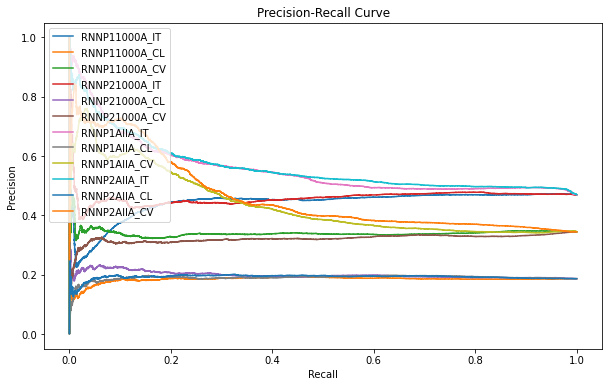

In [ ]:
plot_precision_recall_curve(df_abstract[df_abstract["model_name"] == "RNN"])

# ALL SVC models training on the "abstract" column

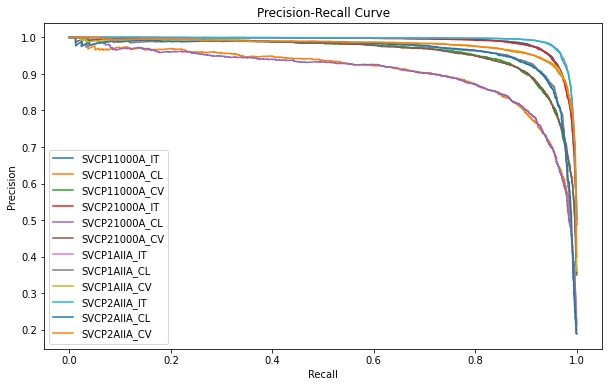

In [ ]:
plot_precision_recall_curve(df_abstract[df_abstract["model_name"] != "RNN"])

# ALL RNN models training on the "title" column

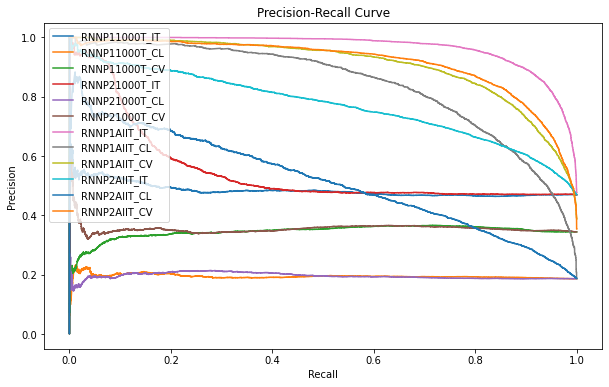

In [ ]:
plot_precision_recall_curve(df_title[df_title["model_name"] == "RNN"])

# ALL SVC models training on the "abstract" column

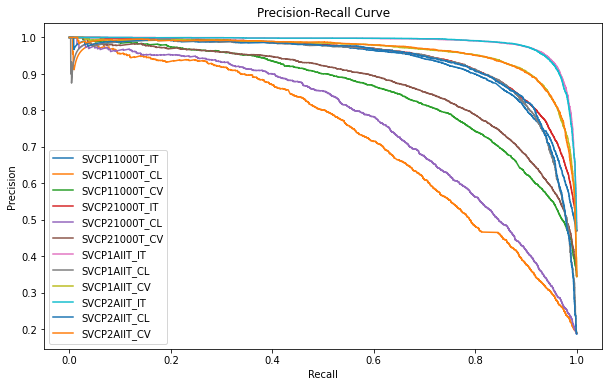

In [ ]:
plot_precision_recall_curve(df_title[df_title["model_name"] != "RNN"])

## Part 2: Topic Modelling



In [ ]:
# !pip3 install pyldavis==2.1.2
# !pip3 install scikit-learn==0.24.2
# !pip install gensim  


[notice] A new release of pip available: 22.1.2 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip
  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'

[notice] A new release of pip available: 22.1.2 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [53 lines of output]
  Partial import of sklearn during the build process.
  <string>:116: DeprecationWarning:
  
    `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
    of the deprecation of `distutils` itself. It will be removed for
    Python >= 3.12. For older Python versions it will remain present.
    It is recommended to use `setuptools < 60.0` for those Python versions.
    For more details, see:
      https://numpy.org/devdocs/reference/distutils_status_migration.html
  
  
  INFO: No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
  Traceback (most recent call last):
    File "C:\Users\Sunny\AppData\Local\Programs\Python\Python310\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 363, in <module>
      main()
    File "C:\Users\Sunny\AppData\Local\Programs\Python\Python310\lib\si


[notice] A new release of pip available: 22.1.2 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import re, nltk, spacy, string

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import pandas as pd
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
from spacy.lang.en.stop_words import STOP_WORDS


In [ ]:
import random
SEED = 1
random.seed(SEED)

In [ ]:
def prepare_data(df_train, tokenizer_func, tokenizer, *args, **kwargs):
    docs = df_train['abstract'].tolist()
    raw_docs = docs.copy()

    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()
        docs[idx] = tokenizer_func(docs[idx], tokenizer, *args, **kwargs)

    bigram = Phrases(docs, min_count=20)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                docs[idx].append(token)

    dictionary = Dictionary(docs)

    dictionary.filter_extremes(no_below=20, no_above=0.5)

    corpus = [dictionary.doc2bow(doc) for doc in docs]

    return corpus, dictionary


In [ ]:
def train_lda(corpus, dictionary, num_topics_range):
    best_avg_topic_coherence = -100
    best_num_topics = 0
    avg_topic_coherence_values = []
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Initialize variables
    best_avg_topic_coherence = -100
    best_num_topics = 0
    avg_topic_coherence_values = []
    for num_topics in num_topics_range:
        print(f"Now processing LDA model with {num_topics} number of topics")
        temp = dictionary[0]
        id2word = dictionary.id2token
        model = LdaModel(
                corpus=corpus,
                id2word=id2word,
                chunksize=chunksize,
                alpha='auto',
                eta='auto',
                iterations=iterations,
                num_topics=num_topics,
                passes=passes,
                eval_every=eval_every,
                )

        top_topics = model.top_topics(corpus)
        avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
        avg_topic_coherence_values.append(avg_topic_coherence)

        if avg_topic_coherence > best_avg_topic_coherence:
            best_avg_topic_coherence = avg_topic_coherence
            best_num_topics = num_topics
            best_model = model
    print(f"Best number of topics: {best_num_topics}, average topic coherence: {best_avg_topic_coherence}")

    # Plot the average topic coherence values for different numbers of topics
    plt.plot(num_topics_range, avg_topic_coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Average Topic Coherence")
    plt.show()
    
    return best_num_topics, best_avg_topic_coherence, avg_topic_coherence_values, best_model


In [ ]:
def plot_topic_coherence(num_topics_range, avg_topic_coherence_values):
    plt.plot(num_topics_range, avg_topic_coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Average Topic Coherence")
    plt.show()

In [ ]:
def get_document_topics(ldamodel, corpus, texts):
   # Init output
    document_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                document_topics_df = document_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    document_topics_df = pd.concat([document_topics_df, contents], axis=1)

    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original_Text']

    return document_topics_df

In [ ]:
def find_top_k_doc(doc_topic_df, k=5):

    doc_topics_sorted_df = pd.DataFrame()

    doc_topic_df_grpd = doc_topic_df.groupby('Dominant_Topic')

    for i, grp in doc_topic_df_grpd:
        doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                          grp.sort_values(['Perc_Contribution'], ascending=[0]).head(k)], 
                                          axis=0)

    doc_topics_sorted_df.reset_index(drop=True, inplace=True)
    doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    return doc_topics_sorted_df

In [ ]:
stop_words = set(STOP_WORDS)

def custom_tokenizer(text, tokenizer, stop_words):
    return [tok for tok in tokenizer.tokenize(text) if tok.lower() not in stop_words]

def custom_tokenizer_P2(text, tokenizer, stemmer):
    return [stemmer.stem(tok) for tok in tokenizer.tokenize(text)]


In [ ]:
import pyLDAvis.gensim
from pprint import pprint

def summarize_lda_results(ldamodel, corpus, dictionary, raw_docs, num_topics, top_k=5):
    # Display LDA visualization
    # lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
    # pyLDAvis.display(lda_display)

    # Get document topics
    doc_topic_df = get_document_topics(ldamodel, corpus, raw_docs)

    # Find top k documents for each topic
    top_k_df = find_top_k_doc(doc_topic_df, k=top_k)


    return doc_topic_df, top_k_df


In [ ]:
train_data = pd.read_csv("train.csv")
train_1000 = train_data.head(1000)
train_data = train_data.head(20000)
test_data = pd.read_csv("test.csv")

# P1 1000

Now processing LDA model with 10 number of topics
Now processing LDA model with 12 number of topics
Now processing LDA model with 14 number of topics
Now processing LDA model with 16 number of topics
Now processing LDA model with 18 number of topics
Best number of topics: 10, average topic coherence: -1.757952894995696


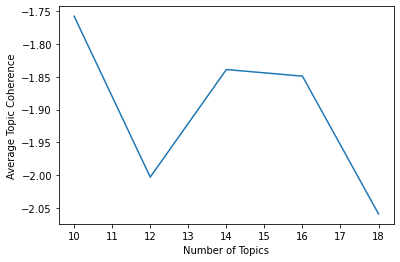

In [ ]:
df_train = train_1000

raw_docs = df_train['abstract'].tolist().copy

tokenizer = RegexpTokenizer(r'\w+')
corpus, dictionary = prepare_data(df_train, custom_tokenizer, tokenizer, stop_words=stop_words)


# Train LDA model
num_topics_range = range(10, 15, 2)
best_num_topics, best_avg_topic_coherence, avg_topic_coherence_values, best_model = train_lda(corpus, dictionary, num_topics_range)

doc_topic_df_P1_1000, top_k_df_P1_1000 = summarize_lda_results(ldamodel=best_model, corpus=corpus, dictionary=dictionary, raw_docs=raw_docs, num_topics=best_num_topics, top_k=5)

lda_display = pyLDAvis.gensim.prepare(best_model, corpus, dictionary, sort_topics=False)

pyLDAvis.display(lda_display)

# P2 1000

Now processing LDA model with 10 number of topics
Now processing LDA model with 12 number of topics
Now processing LDA model with 14 number of topics
Now processing LDA model with 16 number of topics
Now processing LDA model with 18 number of topics
Best number of topics: 10, average topic coherence: -1.4523068232507323


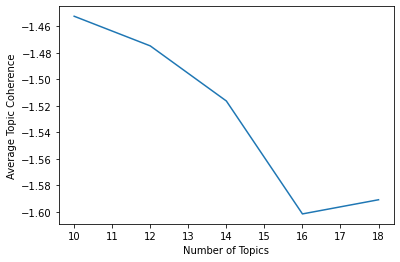

In [ ]:
df_train = train_1000

stemmer = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
corpus, dictionary = prepare_data(df_train, custom_tokenizer_P2, tokenizer, stemmer=stemmer)

# Train LDA model
num_topics_range = range(10, 15, 2)
best_num_topics, best_avg_topic_coherence, avg_topic_coherence_values, best_model = train_lda(corpus, dictionary, num_topics_range)

doc_topic_df_P2_1000, top_k_df_P2_1000 = summarize_lda_results(ldamodel=best_model, corpus=corpus, dictionary=dictionary, raw_docs=raw_docs, num_topics=best_num_topics, top_k=5)

lda_display = pyLDAvis.gensim.prepare(best_model, corpus, dictionary, sort_topics=False)

pyLDAvis.display(lda_display)

# P1 ALL

Now processing LDA model with 10 number of topics
Now processing LDA model with 12 number of topics
Now processing LDA model with 14 number of topics
Now processing LDA model with 16 number of topics
Now processing LDA model with 18 number of topics
Best number of topics: 10, average topic coherence: -1.8275886401598131


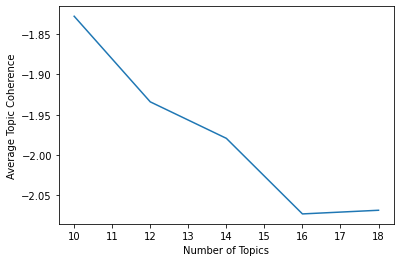

In [ ]:
df_train = train_data

raw_docs = df_train['abstract'].tolist().copy

tokenizer = RegexpTokenizer(r'\w+')
corpus, dictionary = prepare_data(df_train, custom_tokenizer, tokenizer, stop_words=stop_words)


# Train LDA model
num_topics_range = range(10, 15, 2)
best_num_topics, best_avg_topic_coherence, avg_topic_coherence_values, best_model = train_lda(corpus, dictionary, num_topics_range)

doc_topic_df_P1_ALL, top_k_df_P1_ALL = summarize_lda_results(ldamodel=best_model, corpus=corpus, dictionary=dictionary, raw_docs=raw_docs, num_topics=best_num_topics, top_k=5)

lda_display = pyLDAvis.gensim.prepare(best_model, corpus, dictionary, sort_topics=False)

pyLDAvis.display(lda_display)

# P2 ALL

Now processing LDA model with 10 number of topics
Now processing LDA model with 12 number of topics
Now processing LDA model with 14 number of topics
Now processing LDA model with 16 number of topics
Now processing LDA model with 18 number of topics
Best number of topics: 10, average topic coherence: -1.5862593530006017


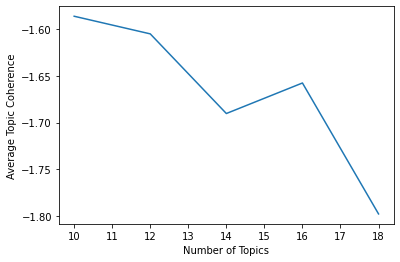

In [ ]:
df_train = train_data

stemmer = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
corpus, dictionary = prepare_data(df_train, custom_tokenizer_P2, tokenizer, stemmer=stemmer)

# Train LDA model
num_topics_range = range(10, 15, 2)
best_num_topics, best_avg_topic_coherence, avg_topic_coherence_values, best_model = train_lda(corpus, dictionary, num_topics_range)

doc_topic_df_P2_ALL, top_k_df_P2_ALL = summarize_lda_results(ldamodel=best_model, corpus=corpus, dictionary=dictionary, raw_docs=raw_docs, num_topics=best_num_topics, top_k=5)

lda_display = pyLDAvis.gensim.prepare(best_model, corpus, dictionary, sort_topics=False)

pyLDAvis.display(lda_display)

In [ ]:
!pip install wordcloud

# Extract the top terms for each topic
num_words = 20  # Number of words to be displayed in the word cloud
topic_words = {}

for i in range(best_num_topics):
    topic_terms = best_model.show_topic(i, num_words)
    topic_words[i] = {word: prob for word, prob in topic_terms}


     ---------------------------------------- 153.1/153.1 kB ? eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip
